 **Importing dependencies**

In [1]:
#Utilities
import pandas as pd 
import numpy as np
import re
import string, time
from collections import defaultdict
!pip install pyspellchecker
from spellchecker import SpellChecker

#Visualization
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import plotly.graph_objects as go
import matplotlib

import matplotlib.patches as mpatches

# Scipy
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix


#Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords.words('english')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, RegexpTokenizer

import spacy

import category_encoders as ce
import gensim
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
import os




**Importing dataset "Natural Language Processing with Disaster Tweets"**

In [8]:
#Description of the columns:

#id - a unique identifier for each tweet
#text - the text of the tweet
#location - the location the tweet was sent from (may be blank)
#keyword - a particular keyword from the tweet (may be blank)
#target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [2]:
#Importing dataset
dataset=pd.read_csv("https://raw.githubusercontent.com/kintis/VKR/main/train.csv")

pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

#Report the number of sentences
print('Number of sentences: {:,}\n'.format(dataset.shape[0]))

#Display 10 random rows from the dataset
dataset.sample(10, random_state=13)


Number of sentences: 7,613



,id,keyword,location,text,target
3738,5313,fire,NaN,Morganite Gemstone White Fire Opal 925 Sterling Silver Ring Size 6 R1354 http://t.co/hHpVSAtQXN http://t.co/D12r8XpShy,0
4809,6845,loud%20bang,NaN,need to work in an office I can bang all my fav Future jams out loud,0
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt: http://t.co/EDyfo6E2PU http://t.co/M5KxLPKFA1,1
1361,1963,burning%20buildings,Spying on your thoughts,@kshllcenterpri1 @Progress4Ohio burning down buildings what you mean like when you burnt down those black churches?,1
2773,3989,devastation,Washington DC,Fascinating pics from inside North Korea. Not propaganda not devastation - just people living life. http://t.co/E2Db...,0
6268,8956,storm,NaN,The Secrets Of The Storm Vortex The Lightning Catcher Book Û_ : http://t.co/OIyWrzL79Z .,0
1063,1534,bomb,"Bolton & Tewkesbury, UK",Hiroshima prepares to remember the day the bomb dropped http://t.co/oJHCGZXLSt,1
4142,5889,harm,"Queensland, Australia",Vanderbilt: First Do No Harm http://t.co/cCdx7CGlQW,0
5312,7585,outbreak,"Ile-Ife,Osun state, Nigeria",#News Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires'... ht...,1
2512,3608,desolation,[marvelÛ¢dragon ageÛ¢wicdiv],i decided to take a break from my emotional destruction to watch tangled then watch desolation of smaug,0


In [3]:
#Remove columns "location" from dataset that has a high proportion of missing values (>33%), column "id" due to unnecessary and "keyword"
data = dataset.drop(columns=['location', 'id', "keyword"])
#Display 10 random rows from the dataset
data.sample(10, random_state=13)

,text,target
3738,Morganite Gemstone White Fire Opal 925 Sterling Silver Ring Size 6 R1354 http://t.co/hHpVSAtQXN http://t.co/D12r8XpShy,0
4809,need to work in an office I can bang all my fav Future jams out loud,0
7600,Evacuation order lifted for town of Roosevelt: http://t.co/EDyfo6E2PU http://t.co/M5KxLPKFA1,1
1361,@kshllcenterpri1 @Progress4Ohio burning down buildings what you mean like when you burnt down those black churches?,1
2773,Fascinating pics from inside North Korea. Not propaganda not devastation - just people living life. http://t.co/E2Db...,0
6268,The Secrets Of The Storm Vortex The Lightning Catcher Book Û_ : http://t.co/OIyWrzL79Z .,0
1063,Hiroshima prepares to remember the day the bomb dropped http://t.co/oJHCGZXLSt,1
4142,Vanderbilt: First Do No Harm http://t.co/cCdx7CGlQW,0
5312,#News Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires'... ht...,1
2512,i decided to take a break from my emotional destruction to watch tangled then watch desolation of smaug,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


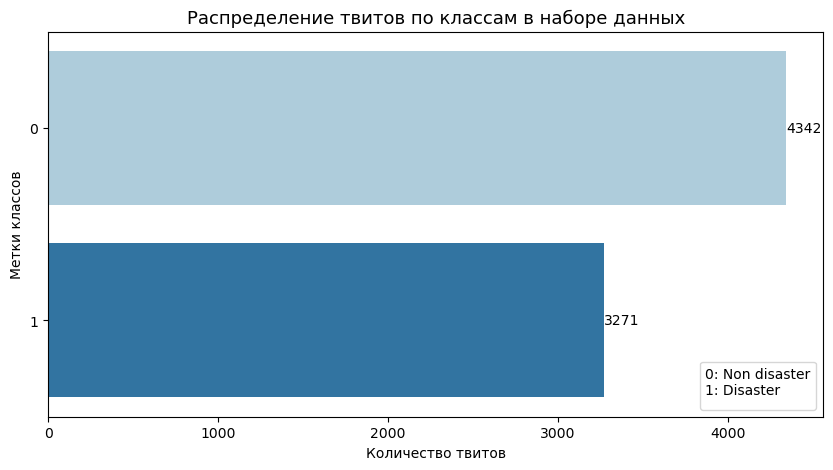

In [4]:
#Visualizing class distribution (1 is real disaster, 0 isn't real disaster)
plt.figure(figsize=(10,5))
ax = sns.countplot(data=data, y='target', palette='Paired')
ax.set_title('Распределение твитов по классам в наборе данных', fontsize=13)
ax.set_xlabel('Количество твитов')
ax.set_ylabel('Метки классов')
for label in ax.containers:
    ax.bar_label(label)
plt.legend(loc='lower right', title="0: Non disaster\n1: Disaster", ncol = 2)
plt.show()

**Text normalization**

In [5]:
# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

In [6]:
# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

text = "This is a FUNCTION that CoNvErTs a Text to lowercase"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))

Input: This is a FUNCTION that CoNvErTs a Text to lowercase
Output: this is a function that converts a text to lowercase


In [7]:
# Substitution of Contractions
# Dictionary of contractions

contractions_url = 'https://raw.githubusercontent.com/kintis/VKR/main/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

print("Example: Original form of the contraction 'aren't' is '{}'".format(contractions_dict["aren't"]))

Example: Original form of the contraction 'aren't' is 'are not'


In [8]:
# Dataframe of contractions
pd.DataFrame(contractions_dict.items(), columns = ['contraction', 'original']).head()

# List of contractions
contractions_list = list(contractions_dict.keys())

# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    
    text_converted = " ".join(words)
    return text_converted

text = "he's doin' fine"
print("Input: {}".format(text))
print("Output: {}".format(convert_contractions(text)))


Input: he's doin' fine
Output: he is doing fine


**Splitting the Data**<br>
The data is divided into 2 sets of data:<br>

Training Data: The dataset upon which the model would be trained on. Contains 80% data.<br>
Test Data: The dataset upon which the model would be tested against. Contains20% data.<br>

In [10]:
TRAIN_SIZE=0.8
# Splits Dataset into Training and Testing set
train_data, test_data = train_test_split(data, test_size=1-TRAIN_SIZE,
                                         random_state=13) 
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

print(train_data.shape)
print(test_data.shape)

Train Data size: 6090
Test Data size 1523
(6090, 2)
(1523, 2)


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6090 entries, 5753 to 338
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6090 non-null   object
 1   target  6090 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.7+ KB


In [12]:
#Comparison of sizes of training set, and test set
values = np.array([len(train_data), len(test_data)])
labels = ['Train set', 'Test set']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Распределение на обучающую и тестовую выборку"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95)) 
fig.show()

In [19]:
train_data["clean_text"] = train_data["text"].apply(convert_to_lowercase).apply(convert_contractions)
train_data["clean_tokens"] = train_data["clean_text"].apply(regexp.tokenize)


test_data["clean_text"] = test_data["text"].apply(convert_to_lowercase).apply(convert_contractions)
test_data["clean_tokens"] = test_data["clean_text"].apply(regexp.tokenize)


**GloVe**

In [23]:
# load the GloVe vectors in a dictionary:
embeddings_index = {}
f = open('.//glove.42B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

1917494it [02:43, 11718.60it/s]

Found 1917494 word vectors.


In [24]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()#.decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [25]:
xtrain_glove = [sent2vec(x) for x in tqdm(train_data['text'])]


100%|██████████| 6090/6090 [00:02<00:00, 2602.18it/s]


In [26]:
xtest_glove = [sent2vec(x) for x in tqdm(test_data['text'])]

100%|██████████| 1523/1523 [00:00<00:00, 3617.31it/s]


In [27]:
xtrain_glove = np.array(xtrain_glove)
xtest_glove = np.array(xtest_glove)

**Machine learning models**

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import optuna
from sklearn.preprocessing import MaxAbsScaler

In [29]:
#Initialize a scaler to normalize the features
scaler = MaxAbsScaler()

#Test options and evaluation metric
num_folds = 5
seed = 13
scoring = 'accuracy'
y_train=train_data['target']
y_test=test_data['target']

In [30]:
#Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('KN', KNeighborsClassifier(n_jobs=-1)))
models.append(('GNB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))
models.append(('XGB', XGBClassifier(n_jobs=-1)))
models.append(('PA', PassiveAggressiveClassifier(n_jobs=-1)))


In [31]:
#GloVe
results_glv = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, xtrain_glove, y_train, cv=kfold, scoring=scoring, error_score='raise')
    results_glv.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.804269 (0.008220)
KN: 0.787192 (0.006955)
GNB: 0.780131 (0.005280)
SVM: 0.812808 (0.005759)
DT: 0.684893 (0.009538)
RF: 0.800328 (0.005721)
XGB: 0.800985 (0.004363)
PA: 0.762890 (0.049396)


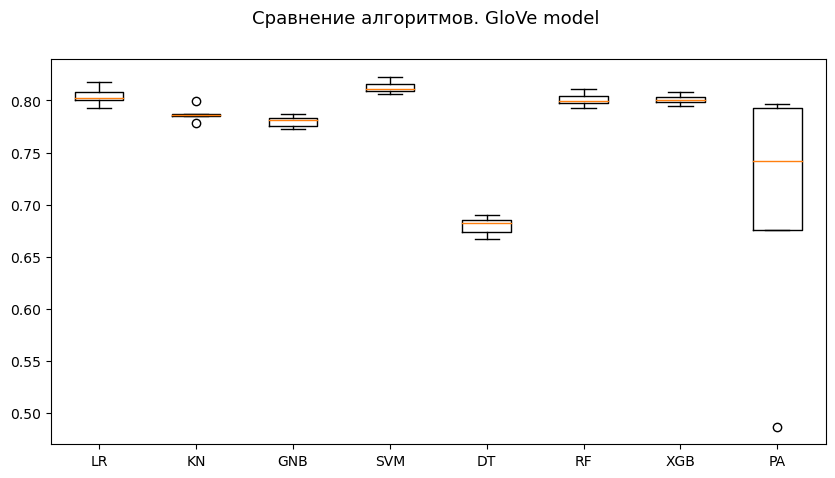

In [171]:
#Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Сравнение алгоритмов. GloVe model', fontsize=13)
ax = fig.add_subplot(111)
plt.boxplot(results_glv)
ax.set_xticklabels(names)
plt.show()

In [173]:
#Standardize the dataset
#glv
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', MaxAbsScaler()),('LR', LogisticRegression(n_jobs=-1))])))
pipelines.append(('ScaledKN', Pipeline([('Scaler', MaxAbsScaler()),('KN', KNeighborsClassifier(n_jobs=-1))])))
pipelines.append(('ScaledGNB', Pipeline([('Scaler', MinMaxScaler()),('GNB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', MaxAbsScaler()),('SVM', SVC())])))
pipelines.append(('ScaledDT', Pipeline([('Scaler', MaxAbsScaler()),('DT', DecisionTreeClassifier())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', MaxAbsScaler()),('RF', RandomForestClassifier(n_jobs=-1))])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', MaxAbsScaler()),('XGB', XGBClassifier(n_jobs=-1))])))
pipelines.append(('ScaledPA', Pipeline([('Scaler', MaxAbsScaler()),('PA', PassiveAggressiveClassifier(n_jobs=-1))])))
results_glv_s = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, xtrain_glove, y_train, cv=kfold, scoring=scoring)
    results_glv_s.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


ScaledLR: 0.798851 (0.006810)
ScaledKN: 0.785714 (0.010527)
ScaledGNB: 0.780131 (0.005280)
ScaledSVM: 0.822332 (0.006372)
ScaledDT: 0.684401 (0.010624)


  0%|          | 0/6090 [14:19<?, ?it/s]


ScaledRF: 0.800821 (0.005130)
ScaledXGB: 0.800985 (0.004363)
ScaledPA: 0.715928 (0.059545)


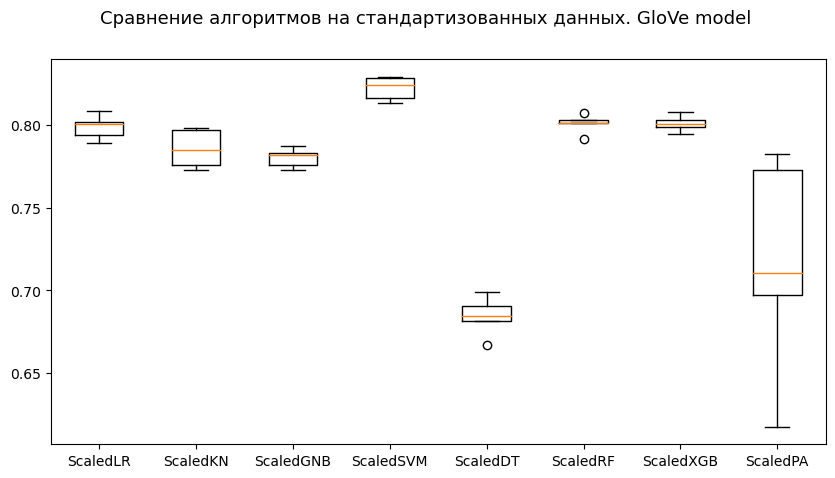

In [174]:
#Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Сравнение алгоритмов на стандартизованных данных. GloVe model', fontsize=13)
ax = fig.add_subplot(111)
plt.boxplot(results_glv_s)
ax.set_xticklabels(names)
plt.show()

In [175]:
print("Optuna Version : {}".format(optuna.__version__))

Optuna Version : 3.1.1


**LogisticRegression (GloVe)**

In [190]:
#glv model
#LogisticRegression

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

#Define the logistic regression model with the hyperparameters
lr_glv = LogisticRegression(penalty= 'l2', C=1.447511476076564, solver='liblinear')

# Perform kFold cross-validation and return the mean validation score
scores = cross_val_score(lr_glv, xtrain_glove, y_train, cv=kfold, scoring=scoring).mean()
 
#Train the logistic regression model 
lr_glv.fit(xtrain_glove, y_train)


#Evaluate the performance of the model on the testing set
predictions_lr = lr_glv.predict(xtest_glove)

print(scores)


0.8057471264367816


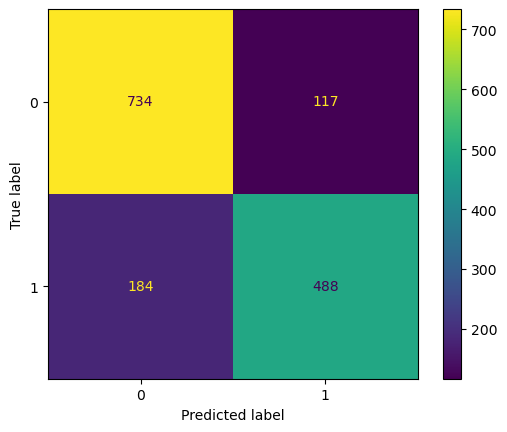

              precision    recall  f1-score   support

           0      0.800     0.863     0.830       851
           1      0.807     0.726     0.764       672

    accuracy                          0.802      1523
   macro avg      0.803     0.794     0.797      1523
weighted avg      0.803     0.802     0.801      1523



In [191]:
#Confusion matrix
cm=confusion_matrix(y_test, predictions_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test, predictions_lr, digits=3))

In [192]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("F1-score: ", f1_score(predictions_lr, y_test))
print("Precision: ", precision_score(predictions_lr, y_test))
print("Recall: ", recall_score(predictions_lr, y_test))
print("Acuracy: ", accuracy_score(predictions_lr, y_test))

F1-score:  0.7642913077525451
Precision:  0.7261904761904762
Recall:  0.8066115702479338
Acuracy:  0.8023637557452397


**KNeighborsClassifier (GloVe)**

In [193]:

#glv
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)


#Define the KNN model with the hyperparameters
knn_glv = KNeighborsClassifier(n_neighbors=21, weights='uniform', metric='manhattan', algorithm='auto')

# Perform kFold cross-validation and return the mean validation score
scores = cross_val_score(knn_glv, xtrain_glove, y_train, cv=kfold, scoring=scoring, n_jobs=-1).mean()

#Train the KNN model 
knn_glv.fit(xtrain_glove, y_train)

#Evaluate the performance of the model on the testing set
predictions_knn = knn_glv.predict(xtest_glove)

print(scores)




0.8001642036124794


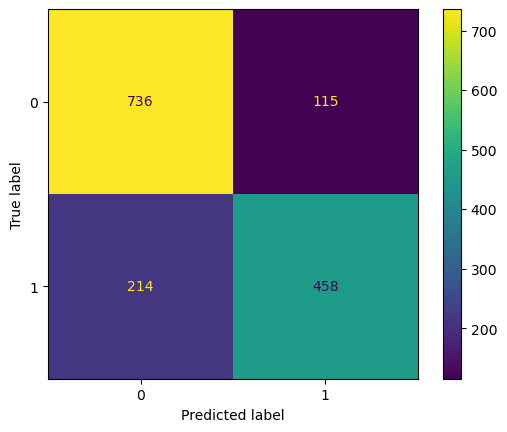

              precision    recall  f1-score   support

           0      0.775     0.865     0.817       851
           1      0.799     0.682     0.736       672

    accuracy                          0.784      1523
   macro avg      0.787     0.773     0.777      1523
weighted avg      0.786     0.784     0.781      1523



In [194]:
#Confusion matrix KN_glv
cm=confusion_matrix(y_test, predictions_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test, predictions_knn, digits=3))

In [195]:

print("F1-score: ", f1_score(predictions_knn, y_test))
print("Precision: ", precision_score(predictions_knn, y_test))
print("Recall: ", recall_score(predictions_knn, y_test))
print("Acuracy: ", accuracy_score(predictions_knn, y_test))

F1-score:  0.7357429718875503
Precision:  0.6815476190476191
Recall:  0.7993019197207679
Acuracy:  0.7839789888378201


**Support Vector Classification (GloVe)**

In [187]:
#glv
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)



#Define the SVM model with the hyperparameters
svc_glv = SVC(C=1.3000000000000003, kernel='rbf') 


# Perform kFold cross-validation and return the mean validation score
scores = cross_val_score (svc_glv, xtrain_glove, y_train, cv=kfold, scoring=scoring).mean()
  

#Train the SVM model 
svc_glv.fit(xtrain_glove, y_train)


#Evaluate the performance of the model on the testing set
predictions_svc = svc_glv.predict(xtest_glove)

print(scores)

0.8142857142857143


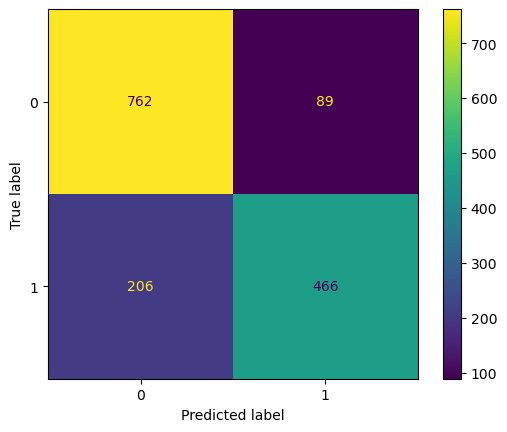

              precision    recall  f1-score   support

           0      0.787     0.895     0.838       851
           1      0.840     0.693     0.760       672

    accuracy                          0.806      1523
   macro avg      0.813     0.794     0.799      1523
weighted avg      0.810     0.806     0.803      1523



In [188]:
#Confusion matrix SVC_glv
cm=confusion_matrix(y_test, predictions_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test, predictions_svc, digits=3))

In [196]:

print("F1-score: ", f1_score(predictions_svc, y_test))
print("Precision: ", precision_score(predictions_svc, y_test))
print("Recall: ", recall_score(predictions_svc, y_test))
print("Acuracy: ", accuracy_score(predictions_svc, y_test))

F1-score:  0.7595762021189894
Precision:  0.6934523809523809
Recall:  0.8396396396396396
Acuracy:  0.8063033486539725


**RandomForestClassifier (GloVe)**

In [198]:
#glv
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)



#Define the RF model with the hyperparameters
rf_glv = RandomForestClassifier(n_estimators=300, max_depth=45,
                                   min_samples_split=8, min_samples_leaf=3, n_jobs=-1) 



# Perform kFold cross-validation and return the mean validation score
scores = cross_val_score(rf_glv, xtrain_glove, y_train, cv=kfold, scoring=scoring).mean()


#Train the RF model 
rf_glv.fit(xtrain_glove, y_train)

#Evaluate the performance of the model on the testing set
predictions_rf = rf_glv.predict(xtest_glove)

print(scores)

0.8050903119868635


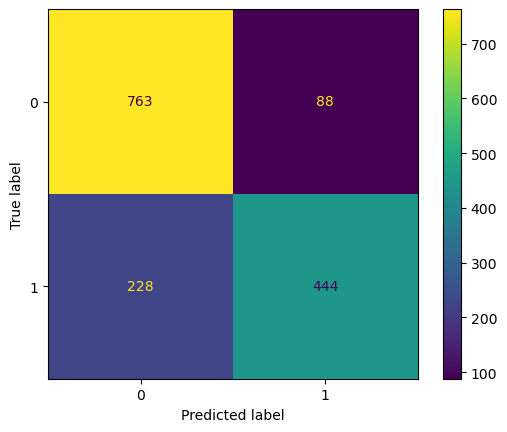

              precision    recall  f1-score   support

           0      0.770     0.897     0.828       851
           1      0.835     0.661     0.738       672

    accuracy                          0.793      1523
   macro avg      0.802     0.779     0.783      1523
weighted avg      0.798     0.793     0.788      1523



In [199]:
#Confusion matrix RF_W2V
cm=confusion_matrix(y_test, predictions_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test, predictions_rf, digits=3))

In [200]:

print("F1-score: ", f1_score(predictions_rf, y_test))
print("Precision: ", precision_score(predictions_rf, y_test))
print("Recall: ", recall_score(predictions_rf, y_test))
print("Acuracy: ", accuracy_score(predictions_rf, y_test))

F1-score:  0.7375415282392027
Precision:  0.6607142857142857
Recall:  0.8345864661654135
Acuracy:  0.7925147734734077


**PassiveAggressiveClassifier (GloVe)**

In [201]:
#glv
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)


#Define the logistic regression model with the hyperparameters
pa_glv = PassiveAggressiveClassifier(C=0.025418180825830413, fit_intercept=True, max_iter=700, tol= 0.0002994821711886301, loss='hinge', average=True, 
                                             class_weight=None, n_jobs=-1)


# Perform kFold cross-validation and return the mean validation score
scores = cross_val_score(pa_glv, xtrain_glove, y_train, cv=kfold, scoring=scoring).mean()


pa_glv.fit(xtrain_glove, y_train)


#Evaluate the performance of the model on the testing set
predictions_pa = pa_glv.predict(xtest_glove)

print(scores)


0.8065681444991789


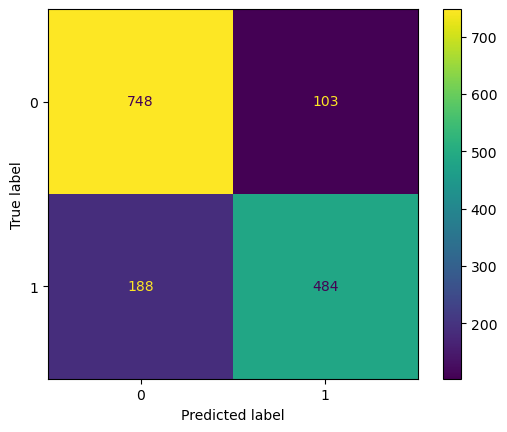

              precision    recall  f1-score   support

           0      0.799     0.879     0.837       851
           1      0.825     0.720     0.769       672

    accuracy                          0.809      1523
   macro avg      0.812     0.800     0.803      1523
weighted avg      0.810     0.809     0.807      1523



In [202]:
#Confusion matrix PA_glv
cm=confusion_matrix(y_test, predictions_pa)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test, predictions_pa, digits=3))

In [203]:

print("F1-score: ", f1_score(predictions_pa, y_test))
print("Precision: ", precision_score(predictions_pa, y_test))
print("Recall: ", recall_score(predictions_pa, y_test))
print("Acuracy: ", accuracy_score(predictions_pa, y_test))

F1-score:  0.7688641779189833
Precision:  0.7202380952380952
Recall:  0.8245315161839863
Acuracy:  0.8089297439264609


**XGBoost (GloVe)**

In [204]:
#glv
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)


    
#Define the XGB model with the hyperparameters
xgb_glv = XGBClassifier(n_estimators=271, gamma=0.06111941963702434, max_depth=9, min_child_weight=5, subsample=0.810387387553235, reg_lambda=0.11850703628113282, 
                                           reg_alpha=0.07855988038201753, colsample_bytree=0.8038485247429074, learning_rate=0.2851234126368579)

# Perform kFold cross-validation and return the mean validation score
scores = cross_val_score(xgb_glv, xtrain_glove, y_train, cv=kfold, scoring=scoring).mean()
  


#Train the XGB model 
xgb_glv.fit(xtrain_glove, y_train)

#Evaluate the performance of the model on the testing set
predictions_xgb = xgb_glv.predict(xtest_glove)

In [207]:
print(scores)

0.7996715927750411


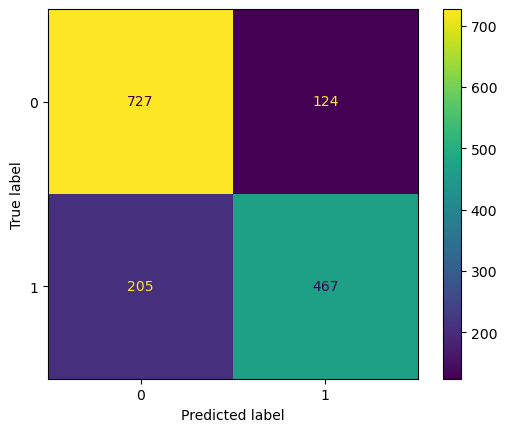

              precision    recall  f1-score   support

           0      0.780     0.854     0.815       851
           1      0.790     0.695     0.740       672

    accuracy                          0.784      1523
   macro avg      0.785     0.775     0.777      1523
weighted avg      0.785     0.784     0.782      1523



In [205]:
#Confusion matrix XGB_glv
cm=confusion_matrix(y_test, predictions_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test, predictions_xgb, digits=3))

In [206]:
print("F1-score: ", f1_score(predictions_xgb, y_test))
print("Precision: ", precision_score(predictions_xgb, y_test))
print("Recall: ", recall_score(predictions_xgb, y_test))
print("Acuracy: ", accuracy_score(predictions_xgb, y_test))

F1-score:  0.7395091053048296
Precision:  0.6949404761904762
Recall:  0.7901861252115059
Acuracy:  0.7839789888378201


**DecisionTreeClassifier (GloVe)**

In [208]:
#glv
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    
#Define the DT model with the hyperparameters
dt_glv = DecisionTreeClassifier(max_depth=9, min_samples_split=10, min_samples_leaf=3, max_features='sqrt')


# Perform kFold cross-validation and return the mean validation score
scores = cross_val_score(dt_glv, xtrain_glove, y_train, cv=kfold, scoring=scoring).mean()



#Train the DT model 

dt_glv.fit(xtrain_glove, y_train)


#Evaluate the performance of the model on the testing set
predictions_DT = dt_glv.predict(xtest_glove)

print(scores)

0.7041050903119868


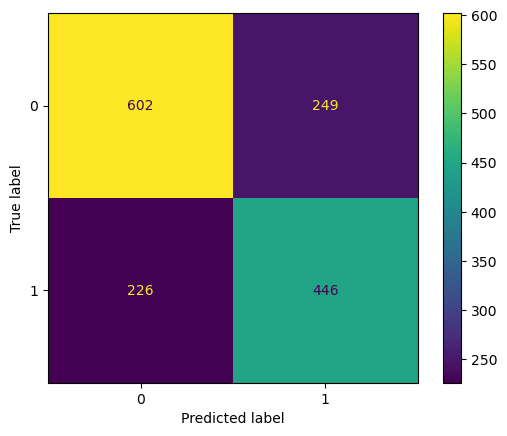

              precision    recall  f1-score   support

           0      0.727     0.707     0.717       851
           1      0.642     0.664     0.653       672

    accuracy                          0.688      1523
   macro avg      0.684     0.686     0.685      1523
weighted avg      0.689     0.688     0.689      1523



In [211]:
#Confusion matrix DT_glv
cm=confusion_matrix(y_test, predictions_DT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()
print(classification_report(y_test, predictions_DT, digits=3))

In [210]:

print("F1-score: ", f1_score(predictions_DT, y_test))
print("Precision: ", precision_score(predictions_DT, y_test))
print("Recall: ", recall_score(predictions_DT, y_test))
print("Acuracy: ", accuracy_score(predictions_DT, y_test))

F1-score:  0.6525237746891002
Precision:  0.6636904761904762
Recall:  0.641726618705036
Acuracy:  0.6881155613919895
